## Imports

In [1]:
#multi channel CNN for sentiment analysis
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from string import punctuation
from os import remove
import pandas as pd
import numpy as np
import re
import fasttext
import word2vecReader as godin_embedding
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from math import sqrt
from gensim.models import KeyedVectors
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loading data and pre-processing

In [2]:
#loading data
def load_data_from_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    sentences = list()
    score= list()
    for row in root:
        score.append(float(row[1].text))
        sentences.append(row[2].text)
    return sentences,score

In [3]:
sentences,score = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')

In [4]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [5]:
# extract sentences out of df and cleaning it
sentences = [clean_sentence(x) for x in sentences]
# sentences

In [6]:
#converting real number scores to lables
#0-->-ve sentiment 1-->+ve sentiment
labels = [1 if x >= 0 else 0 for x in score]

In [7]:
def shuffle_data(sentences,labels,score):
    numbers = [i for i in range(len(sentences))]
    shuffle(numbers)
    temp_text = sentences
    temp_lables = labels
    temp_score = score
    for i in numbers:
        sentences[i] = temp_text[i]
        labels[i]=temp_lables[i]
        score[i] = temp_score[i]
    print(len(sentences))
    print(len(labels))
    print(len(score))
    return sentences,labels,score

In [8]:
sentences,labels,score = shuffle_data(sentences,labels,score)

675
675
675


In [9]:
#doing train and train split
test_train_split_ratio =0.9
trainX,testX = sentences[:int(test_train_split_ratio*len(sentences))],sentences[int(test_train_split_ratio*len(sentences)):]
trainY,testY = labels[:int(test_train_split_ratio*len(labels))],labels[int(test_train_split_ratio*len(labels)):]
score_trainY,score_testY = score[:int(test_train_split_ratio*len(score))],score[int(test_train_split_ratio*len(score)):]

In [10]:
print(len(trainX),len(trainY),len(score_trainY))
print(len(testX),len(testY),len(score_testY))

607 607 607
68 68 68


In [11]:
# testY[0]

In [12]:
#converting output matrix [-ve,+ve]
testY = to_categorical(testY,2)
trainY = to_categorical(trainY,2)
# testY[:7]

In [13]:
# testY[6]

In [14]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [16]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
lengths = [len(s.split()) for s in trainX]
max_length = max(lengths)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 21
Vocabulary size: 2043
(607, 21) (68, 21)


(array([0.04365733, 0.07495881, 0.09143328, 0.08649094, 0.07825371,
        0.06507414, 0.03624382, 0.01812191, 0.00411862, 0.00164745]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <a list of 10 Patch objects>)

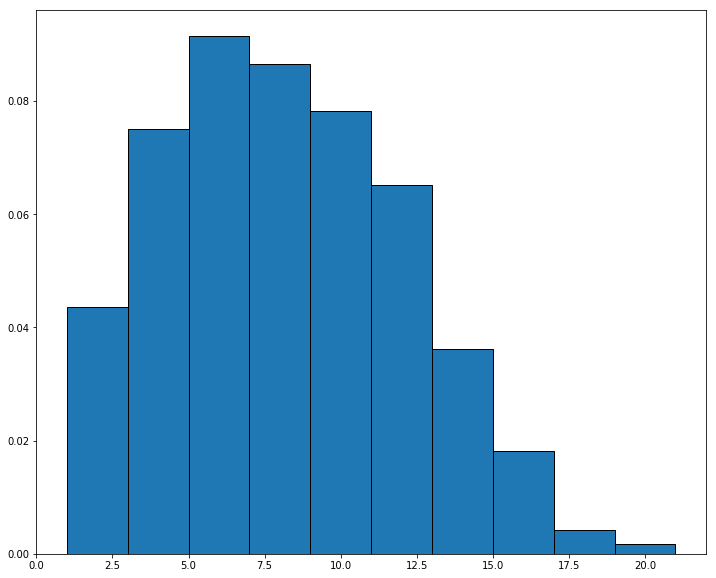

In [17]:
plt.subplots(figsize=(12,10))
plt.hist(lengths, normed=True,edgecolor='black')

considring only few sentences have len >15, we can also take max_len = 15

## different word embeddings

In [18]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


In [19]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [20]:
embeddings_index_glove = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
embedding_matrix_glove = get_GloVe_embedding_matrix(embeddings_index_glove)
# embedding_matrix[100]
# e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

Loaded 400000 word vectors.


In [21]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [22]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [100]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [23]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
#                 sentence = sentence.encode('UTF-8')
#                 print(sentence)
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [24]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [122]:
fast_text_model = load_fast_text_model(trainLines+testLines)
embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)

traning new model
model trained


In [18]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [23]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix


In [24]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
embedding_matrix_godin = get_godin_embedding_matrix(godin_model)

Loading the model, this can take some time...


## Hyper Parameters

In [25]:
para_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',name='learning_rate')

In [26]:
para_dropout = Real(low=0.4, high=0.9,name = 'dropout')

In [27]:
# para_n_dense = Integer(low=100, high=400, name='n_dense')
para_n_dense = Categorical(categories=[100,200,300,400], name='n_dense')

In [28]:
# para_n_filters = Integer(low=100,high=400,name='n_filters')
para_n_filters = Categorical(categories=[100,200,300,400],name='n_filters')

In [29]:
para_filter_size_c1 = Integer(low=1,high=6,name = 'filter_size_c1')

In [30]:
para_filter_size_c2 = Integer(low=1,high=6,name = 'filter_size_c2')

In [31]:
para_filter_size_c3 = Integer(low=1,high=6,name = 'filter_size_c3')

In [32]:
para_em_c1 = Categorical(categories=['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free'],name='em_c1')

NameError: name 'embedding_matrix_fast_text' is not defined

In [ ]:
para_em_c2 = Categorical(categories=['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free'],name='em_c2')

In [ ]:
para_em_c3 = Categorical(categories=['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free'],name='em_c3')

In [2]:
para_em_trainable_flag = Categorical(categories=[True,False],name='em_trainable_flag')

In [3]:
para_free_em_dim = Categorical(categories=[100,300,400],name='free_em_dim')

In [4]:
para_batch_size = Categorical(categories=[50,100,150],name='batch_size')

In [5]:
para_epoch = Categorical(categories=[10,50,100,200,300,400,500],name='epoch')

In [36]:
parameters = [para_learning_rate,para_dropout,para_n_dense,para_n_filters,para_filter_size_c1,para_filter_size_c2,para_filter_size_c3,para_em_c1,para_em_c2,para_em_c3,para_em_trainable_flag,para_free_em_dim,para_batch_size,para_epoch]

NameError: name 'para_em_c1' is not defined

In [37]:
default_parameters = [1e-4,0.5,100,100,2,4,6,'embedding_matrix_word2vec','embedding_matrix_glove','free',False,100,50,10]

NameError: name 'embedding_matrix_word2vec' is not defined

## Model

In [7]:
# define the model
def define_model(length,vocab_size,n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,free_em_dim,em_trainable_flag):
    # channel 1
    inputs1 = Input(shape=(length,))
    if em_c1 == 'free':
        embedding1 = Embedding(vocab_size, free_em_dim)(inputs1)
    else:
        embedding1 = Embedding(vocab_size, len(eval(em_c1)[0]), weights = [eval(em_c1)],input_length=length,trainable = em_trainable_flag)(inputs1)

    conv1 = Conv1D(filters=n_filters, kernel_size=filter_size_c1, activation='relu')(embedding1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
#     embedding2 = Embedding(vocab_size, 400, weights = [embedding_matrix_godin],input_length=length,trainable = em_trainable_flag)(inputs2)
    if em_c2 == 'free':
        embedding2 = Embedding(vocab_size, free_em_dim)(inputs2)
    else:
        embedding2 = Embedding(vocab_size, len(eval(em_c2)[0]), weights = [eval(em_c2)],input_length=length,trainable = em_trainable_flag)(inputs2)
    conv2 = Conv1D(filters=n_filters, kernel_size=filter_size_c2, activation='relu')(embedding2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
#     embedding3 = Embedding(vocab_size, 400)(inputs3)
    if em_c3 == 'free':
        embedding3 = Embedding(vocab_size, free_em_dim)(inputs3)
    else:
        embedding3 = Embedding(vocab_size, len(eval(em_c3)[0]), weights = [eval(em_c3)],input_length=length,trainable = em_trainable_flag)(inputs3)
    conv3 = Conv1D(filters=n_filters, kernel_size=filter_size_c3, activation='relu')(embedding3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    outputs = Dense(2, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # summarize
#     print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [8]:
#dict to store performance of all models
record = dict()
key=0

In [40]:
@use_named_args(dimensions=dimensions)
def fitness(para_learning_rate,para_dropout,para_n_dense,para_n_filters,para_filter_size_c1,para_filter_size_c2,para_filter_size_c3,para_em_c1,para_em_c2,para_em_c3,para_em_trainable_flag,para_free_em_dim,para_batch_size,para_epoch):

    # Print the hyper-parameters.
    print('learning rate ==>',para_learning_rate)
    print('dropout==>',para_dropout)
    print('n_dense==>',para_n_dense)
    print('n_filters==>',para_n_filters)
    print('filter_size_c1',para_filter_size_c1)
    print('filter_size_c2',para_filter_size_c2)
    print('filter_size_c3',para_filter_size_c3)
    print('em_c1==>',para_em_c1)
    print('em_c2==>',para_em_c2)
    print('em_c3==>',para_em_c3)
    print('em_trainable_flag ==>',para_em_trainable_flag)
    print('free_em_dim==>',para_free_em_dim)
    print('batch_size==>',para_batch_size)
    print('epocs==>',para_epoch)

    # Create the neural network with these hyper-parameters.
    model = define_model(length = max_length,
                         vocab_size=vocab_size,
                         n_dense=para_n_dense,
                         dropout=para_dropout,
                         learning_rate=para_learning_rate,
                         n_filters=para_n_filters,
                         filter_size_c1=para_filter_size_c1,
                         filter_size_c2=para_filter_size_c2,
                         filter_size_c3=para_filter_size_c3,
                         em_c1=para_em_c1,
                         em_c2 = para_em_c2,
                         em_c3=para_em_c3,
                         free_em_dim=para_free_em_dim,
                         em_trainable_flag=para_em_trainable_flag)

    
    # Use Keras to train the model.
    history_object = model.fit([trainX,trainX,trainX], trainY,epochs=para_epoch, batch_size=para_batch_size)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history_object.history['val_acc'][-1]

    # Print the classification accuracy.
    print("Accuracy: {0:.2%}".format(accuracy))
    
    global key
    global record
    record[key] = {'parameters':dimensions,'val_acc':accuracy}
    
    model.save('models/'+str(key)+'.h5')
    
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=500,
                            x0=default_parameters)

In [27]:
print(sorted(zip(search_result.func_vals, search_result.x_iters)))

In [39]:
# fit model
# history_object = model.fit([trainX,trainX,trainX], trainY,epochs=10, batch_size=16)

In [10]:
# plt.subplots(figsize=(12,10))
# plt.plot(history_object.history['acc'])
# # plt.plot(history_object.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# # plt.legend(['train', 'test'], loc='upper left')

In [11]:
# plt.subplots(figsize=(12,10))
# plt.plot(history_object.history['loss'])
# # plt.plot(history_object.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # plt.legend(['train', 'test'], loc='upper left')

In [31]:
#testing
# encode data
# trainX = encode_text(tokenizer, trainLines, length)


In [12]:
# # evaluate model on training dataset
# loss, acc = model.evaluate([trainX,trainX,trainX], trainY, verbose=0)
# print('Train Accuracy: %f' % (acc*100))
 
# # evaluate model on test dataset dataset
# loss, acc = model.evaluate([testX,testX,testX], testY, verbose=0)
# print('Test Accuracy: %f' % (acc*100))

In [210]:
# model.predict([testX,testX,testX])

In [13]:
# def get_predicted_prob(data):
#     return [list(x) for x in model.predict(data)]

In [14]:
#predicted probabilities
# train_predicted_prob = get_predicted_prob([trainX,trainX,trainX])
# test_predicted_prob = get_predicted_prob([testX,testX,testX])
# predicted_prob

In [15]:
# test_predicted_prob

In [16]:
#predicting lables
#if prob>0.5 -->1 else 0
# def get_predicted_lables(prob):
#     predicted_lables = []
#     for x in prob:
#         if x>0.5:
#             predicted_lables.append(1)
#         else:
#             predicted_lables.append(0)
#     return predicted_lables
# def get_predicted_lables(prob):
#     predicted_lables = []
#     for x in prob:
#         if x[0]>x[1]:
#             predicted_lables.append(0)
#         else:
#             predicted_lables.append(1)
#     return predicted_lables

In [17]:
# train_predicted_lables = get_predicted_lables(train_predicted_prob)
# test_predicted_lables = get_predicted_lables(test_predicted_prob)

In [216]:
# train_predicted_lables

In [18]:
# # def get_score_from_prob(prob):
# #     m = interp1d([0,1],[-1,1])
# #     return [float(m(x)) for x in prob]
# def get_score_from_prob(prob):
#     intensity_score = []
#     for x in prob:
#         if x[0]>x[1]:
#             intensity_score.append(-1*x[0])
#         else:
#             intensity_score.append(x[1])
#     return intensity_score

In [19]:
# train_predicted_score = get_score_from_prob(train_predicted_prob)
# test_predicted_score = get_score_from_prob(test_predicted_prob)

In [219]:
# test_predicted_score

In [20]:
# train_rmse = sqrt(mean_squared_error(score_trainY, train_predicted_score))
# test_rmse = sqrt(mean_squared_error(score_testY, test_predicted_score))
# print("(train rmse,test rmse)=="+str((train_rmse,test_rmse)))

In [221]:
# foo = [x for x in zip(score_testY,test_predicted_score)]
# foo